# Cancer Cell Line Atlas Data Prep for QuEStVar

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 


**Notebook Summary:** 

In this notebook I took I've prepared the protein level cancer cell line data from [Gonçalves et al. 2022](https://www.cell.com/cancer-cell/fulltext/S1535-6108(22)00274-4) with replicates information. It is a very large collection of cancer cell line proteomics data. To be able to apply the QuEStVar a series of data checks and processing steps are required and I've implemented them in this notebook. Additionally I've prepare the processed datasets and save them in the `data/processed` folder for the main testing framework to make use of them. 

Prior to direct application of `questvar` on the data, a series of preliminary steps are performed. These include a data check, cleaning, and processing. The notebook facilitates tasks such as data check-up, simple clean-up procedures, visualizations to explore sample completeness and organism effects. Finally, processed data files are generated for utilization in the `questvar` framework in the subsequent notebook.

The processing steps are as follows:

1. Clean the Data
    - Remove highly missing cell-lines (> 80%)
    - Remove quantification of a protein if quantified in less than 25% of cell line samples
    - Replace missing values with protein-cell line average if less than 50% is missing 
2. Shift the Data
    - Move the distribution to fully positive 
4. Pick N best Cell Lines per Subtype, Age, Tumour Status
    - Up to 4 cell lines per subtype, age, tumour status
3. Pick N best Replicate per Cell Line
    - Pick 5 best CV replicates for cell line samples
5. Center the Data
    - Median centering to ensure all samples are centered around data's median

---

**Data Information:**
The data used in this notebook and this part of the analysis is from [Gonçalves et al. 2022](https://www.cell.com/cancer-cell/fulltext/S1535-6108(22)00274-4) and the data can be downloaded from [figshare Repo](https://figshare.com/articles/dataset/Pan-cancer_proteomic_map_of_949_human_cell_lines/19345397). For this notebook I am going to be using the following files accessed on 2023-11-01: 
- `ProCan-DepMapSanger_protein_matrix_8498_replicates.txt` - Contains the protein level data for 8498 proteins and 949 cell lines with replicates information, I've saved this data as `ProCan-DepMapSanger_Protein_data.txt` in the `data/raw` folder.

Additionally the expanded cell line information and the metadata for the replicate information prepared in the previous notebook saved in `data/raw/` folder is used in this notebook. 

The resulting data that is ready to be used in the `questvar` framework is saved in the `data/processed/` folder. As well as all the cell line subsets saved in the `data/processed/samples/` folder to facilitate more memory and time efficient testing of many cell line pairs during testing.

## Setup Notebook

This part is a standard for my notebooks, where I import the all used libraries, set the design of the notebook, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used


In [1]:
import os 
import sys
import feather
import warnings

import numpy as np 
import pandas as pd 

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import matplotlib.ticker as mtick # Format tick marks on plots

sys.path.append('../')
from questvar import utils, plots

warnings.filterwarnings('ignore')
# Initialize the timer
startTime = utils.getTime()

### Notebook's Design

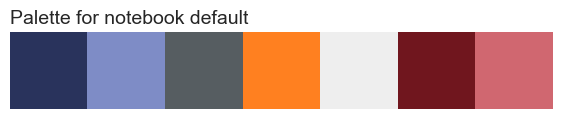

In [2]:
### Notebook Configuration

# Set random seed
np.random.seed(42)

def_colors = ["#29335c","#7e8cc6","#565d61","#ff8020","#eeeeee","#70161e","#d06770"]

## Configure some general styling for the plots
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"] # formats to save figures in
save_to_folder = True           # enable saving figures to folder
transparet_bg = True            # enable transparent background
figure_dpi = 300                # figure resolution

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors,
    name="notebook default",
)

### Data and Result Paths

I keep the data and figures folders seperate to allow for a more organized structure. Also within the data folder I create raw, processed, and in later notebook results folder to seperate each step of the process. 

The raw `data/raw/` folder needs to be present since it should contain the original data. However, the `data/processed/` and `results/` folders are not present at the beginning and will be created by the us within the notebook.

The `data/processed/samples/` folder contains the sample subset files that the main testing function will access when comparing two samples. The reason why I subset and save them seperately is when the number of samples increase and user wants to test all combinations of samples, it is easier to access subsets rather than keep subsetting from a large table. Also this is part of memory optimization that benefits the storage system later on. 

Additionally I create a `figures/` folder to store all the figures generated in the notebook, based on the number of different formats you want to keep subset folders will be made to store the saved figured in those formats.

In [3]:
# Establish the paths
fig_name = "InputPrep"                          # Name of the figure folder
data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{fig_name}/"             # Main figure folder
input_path = f"{data_path}raw/"                 # Input data folder
output_path = f"{data_path}processed/"          # Output data folder
quant_path = f"{output_path}samples/"           # Folder for Subset of sample feather files 

# Check if data/raw folder exists
if not os.path.exists(input_path):
    raise FileNotFoundError(
        "Data folder not found. Please follow the instructions in the README.md file."
    )

# Create folders for output and quant
for i in [output_path, quant_path]:
    if not os.path.exists(i):
        os.makedirs(i)

# Create figure folder structure, if needed
if save_to_folder: 
    for i in figure_formats:
        cur_folder = fig_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)    

## Setup the Data

After the notebook is setup, I start with the raw data and make them useable. Overall my approach stays the same but depending on the data there will be changes that is required. 

### Protein Level Quant Data

The protein-level data is downloaded from [figshare Repo](https://figshare.com/articles/dataset/Pan-cancer_proteomic_map_of_949_human_cell_lines/19345397) and saved in the `data/raw/` folder.  

Based on the information on the DepMap documentation page on the proteomics data [here](https://depmap.sanger.ac.uk/documentation/datasets/proteomics/), the protein quantifications at the replicate level are in log2 transformed format.

The data in original form contains proteins in columns and sample+replicates in rows. I will transpose the data to have samples in columns and proteins in rows. This will make it easier to work with the data and bring it to non-log2 transformed format by multiplying the values by the power of 2.

The protein ids are saved as accession;proteinName. I will only keep the accession part of the protein id and save it as the index of the dataframe. 

In [4]:
data = pd.read_csv(
    input_path+'ProCan-DepMapSanger_Protein_data.txt', 
    sep="\t"
).set_index("Unnamed: 0").T
# Inverse log2
data = 2**data
data.index = data.index.str.split(";").str[0]
data.index.name = "Acc_id"
data.columns.name = ""
print("Data shape:", data.shape)
print("Preview of 5 row and 5 columns:")
data.head().iloc[:, :5]

Data shape: (8498, 6864)
Preview of 5 row and 5 columns:


,190127_8751_004ro_008lv_m06_s_1,191024_b49-t2-3_00dnt_00knn_m04_s_1,181211_2223_0043w_006t2_m03_s_1,191021_b56-t2-13_00dr7_00kl3_m05_s_1,180907_e0022_p02_hek_122_s_m06_1
Acc_id,,,,,
Q9Y651,4.5017,7.3931,4.1189,10.0588,3.5348
P37108,178.1617,212.8801,39.2837,116.2720,60.0265
Q96JP5,11.2340,10.9185,NaN,24.4272,8.9282
Q9Y4H2,NaN,NaN,NaN,NaN,NaN
P36578,177.2066,101.7097,34.6726,45.2756,106.4123


### Create Cell Line Metadata for Replicates

In here I will open the cell line information file and the replicate information file and merge them together to create a cell line metadata file that contains the cell line information and the replicate information.

I will use the simplified ColumnName created in the previous notebook to replace the original column names in the replicate information file. Update the quant data columns to have the simplified column names, remove the original column names from the replicate information file.

In [5]:
# Open the cell line annotation
cell_info_cur = pd.read_csv(
    f"{input_path}final_cell_line_annotation.csv"
).set_index("SIDM").iloc[:, 1:]

# Open the replica metadata
replica_meta = pd.read_csv(
    f"{input_path}cleaned_replica_metadata.csv"
).set_index("SIDM")
# Create a column with the batch information
replica_meta["Batch"] = replica_meta["VarianceID"].apply(lambda x: x.split("|")[0])
# Merge the cell line annotation to the replica metadata
replica_meta = replica_meta.join(cell_info_cur)

# Order the quant data by the sorted filenames
data = data[replica_meta["Automatic_MS_filename"]]
# Rename the quant data columns by cleaner column names
data.columns = replica_meta["ColumnName"]

replica_meta = replica_meta.drop(["Automatic_MS_filename"], axis=1).reset_index()
# replica_meta.to_csv(output_path+"initial_metadata.csv", index=False)

print("Replica metadata shape:", replica_meta.shape)
replica_meta.head()

Replica metadata shape: (4978, 15)


,SIDM,ColumnName,UniqueSample,VarianceID,Cell_line,Replicate,Batch,Sex,Age,Status,Collection_site,System_name,Tissue_type,Cancer_type,Cancer_subtype
0,SIDM00018,M01|P05|SIDM00018|1,M01|P05|SIDM00018,M01|P05,K052,1,M01,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
1,SIDM00018,M03|P05|SIDM00018|1,M03|P05|SIDM00018,M03|P05,K052,1,M03,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
2,SIDM00018,M05|P05|SIDM00018|1,M05|P05|SIDM00018,M05|P05,K052,1,M05,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
3,SIDM00018,M06|P05|SIDM00018|1,M06|P05|SIDM00018,M06|P05,K052,1,M06,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
4,SIDM00018,M06|P05|SIDM00018|2,M06|P05|SIDM00018,M06|P05,K052,2,M06,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia


### Make Unique Metadata

This will be the metadata that only contain the unique cell line and info about them. I will also highlight the variables representing the cell line:

In [6]:
# Create a unique cell line and annotation metadata
metadata = replica_meta[
    [
        "SIDM",
        "Cell_line", 
        "System_name", 
        "Tissue_type", 
        "Cancer_type", 
        "Cancer_subtype", 
        "Collection_site",
        "Status",
        "Age", 
        "Sex"
    ]
].drop_duplicates().sort_values([
    "System_name",
    "Tissue_type",
    "Cancer_type",
    "Cancer_subtype",
    "Status",
    "Age",
    "Sex"
]).reset_index(drop=True)

print("Metadata shape:", metadata.shape)
print("Cell lines (SIDM):", len(metadata["SIDM"].unique()))
print("Cell lines (Names):", len(metadata["Cell_line"].unique()))
print("Systems:", len(metadata["System_name"].unique()))
print("Tissues:", len(metadata["Tissue_type"].unique()))
print("Cancer types:", len(metadata["Cancer_type"].unique()))
print("Cancer subtypes:", len(metadata["Cancer_subtype"].unique()))
print("Collection sites:", len(metadata["Collection_site"].unique()))
print("Status:", len(metadata["Status"].unique()), metadata["Status"].unique())
print("Ages:", len(metadata["Age"].unique()), metadata["Age"].unique())
metadata.head()

Metadata shape: (814, 10)
Cell lines (SIDM): 814
Cell lines (Names): 814
Systems: 11
Tissues: 25
Cancer types: 42
Cancer subtypes: 102
Collection sites: 36
Status: 2 ['Primary' 'Metastatic']
Ages: 2 ['Adult' 'Child']


,SIDM,Cell_line,System_name,Tissue_type,Cancer_type,Cancer_subtype,Collection_site,Status,Age,Sex
0,SIDM00772,HCC2218,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
1,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
2,SIDM00875,HCC1806,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
3,SIDM00879,HCC1500,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
4,SIDM00629,MDA-MB-436,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Pleural_effusion,Metastatic,Adult,Female


At the beginning of the data cleaning and processing notebook we have 814 cell lines over 11 Systems, 25 Tissues, 42 Cancer, 102 Subtype and 2 Tumour/Age Status.

# Data Cleaning

Because the main purpose of our analysis do apply the statistical testing on the data, I need to ensure the data is clean and ready to be used. I am going to check the data from various aspects and clean it accordingly.

In [7]:
## Create useful dictionaries to be used in the analysis
# Create a custom palette for the Tissues
cust_pal = sns.color_palette("tab20", metadata["Tissue_type"].unique().shape[0]) 
# Create a dictionary of the tissue types and colors
tissue_labels = dict(zip(metadata["Tissue_type"].sort_values().unique(), list(cust_pal.as_hex())))
# Create a dictionary to hold Cell-line: Tissue
cell_tissue = dict(zip(metadata["SIDM"], metadata["Tissue_type"]))
# Create a dictionary to hold Tissue: Cell-line
tissue_cell = metadata.groupby("Tissue_type").apply(lambda x: list(x["SIDM"])).to_dict()
# Create Cell_Line: ColumnName Dictionary
lp_dict = replica_meta.groupby(["SIDM"]).apply(lambda x: list(x["ColumnName"])).to_dict()

## Filtering the Cell Lines

As the first step I will remove some of the cell lines that are not fit for the upcoming analysis. There are a few reasons why I would remove a cell line from the analysis.

1. Replicate number is less than 6
2. Cell line missing more than 80% of the proteins
3. Sampling up to 3 cell lines per subtype, age, tumour status

### Remove Less than 6 Replicate CLs

This steps ensures we have at least certain amount of replicates so the testing can be done with a certain confidence. I've decided to keep cell lines with at least 6 replicates to increase the confidence in the results.

Drop cell lines with less than 6 replicas
--------------------------------------------------
Number of cell lines - before: 814


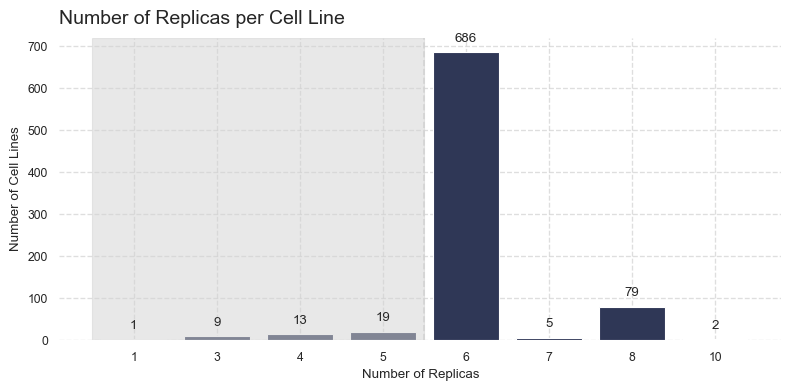

In [8]:
# Drop cell lines with less certain number of replicas
cur_cutoff = 6
# print("Drop cell lines with less than 6 replicas")
print("Drop cell lines with less than {} replicas".format(cur_cutoff))
print("-" * 50)
print("Number of cell lines - before:", len(replica_meta["SIDM"].unique()))

# Preview the number of replicas per cell line
fig, ax = plt.subplots(
    1, 1, 
    figsize=(8, 4)
)
sns.countplot(
    replica_meta["SIDM"].value_counts(), 
    color=def_colors[0],
    ax=ax,
)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()-0.5), 
        ha = 'center', va = 'center', 
        xytext = (0, 10), 
        textcoords = 'offset points'
    )

# Add grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

ax.set_ylabel(
    "Number of Cell Lines"
)
ax.set_xlabel(
    "Number of Replicas"
)
ax.set_title(
    "Number of Replicas per Cell Line", 
    fontsize=14,
    loc="left",
    pad=10 
)

plt.axvline(
    3.5, 
    color='lightgray', 
    linestyle='--'
)
plt.axvspan(
    -0.5, 
    3.5, 
    alpha=0.5, 
    color='lightgray'
)

sns.despine(
    left=True, 
    bottom=True
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "ReplicaPerCellLine_barplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

In [9]:
# Drop cell lines if they have less than selected cutoff
cell_line_counts = replica_meta["SIDM"].value_counts()
cell_line_counts = cell_line_counts[cell_line_counts >= cur_cutoff]
replica_meta = replica_meta[replica_meta["SIDM"].isin(cell_line_counts.index)]
print("Number of cell lines - after:", len(cell_line_counts))

Number of cell lines - after: 772


There are 42 cell lines that have less than 6 replicates as shown in the graph with gray background. Those cell lines are removed from the replica_meta table and won't be used in the analysis.

### High Missing Value Cell Lines (>=80%)

I also want to remove the cell lines that are quantified very small number of proteins less than 20% of the 8498 proteins. Because the cell lines contain at least 6 replicates, I will consider a protein to be missing if more than 4 replicates are missing or equivalently less than 60% of the replicates are quantified.

Drop proteins with more than 80% missing proteins
Missingness criteria for protein is missing in more than 40% of replicates
--------------------------------------------------
Number of cell lines - before: 772
Number of cell lines - after: 772


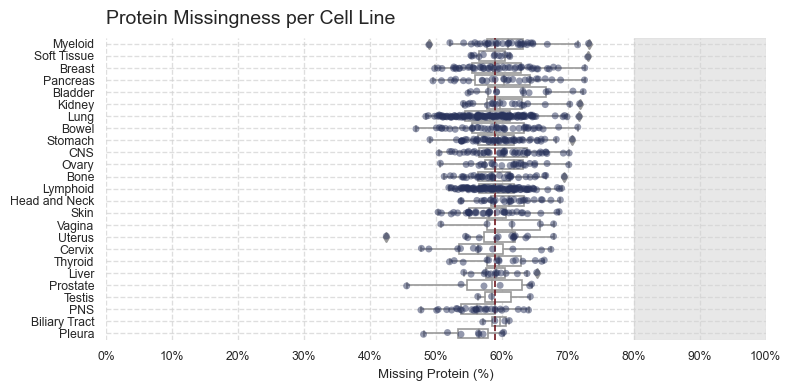

In [10]:
# Drop proteins with more than centain percent of missing values
cur_cutoff = 80 # 80%
cur_prot_miss_cutoff = 40 # 40%
print(f"Drop proteins with more than {cur_cutoff}% missing proteins")
print(f"Missingness criteria for protein is missing in more than {cur_prot_miss_cutoff}% of replicates")
print("-" * 50)
print("Number of cell lines - before:", len(replica_meta["SIDM"].unique()))

# Calculate a custom percentage for missing values per Cell Line
# Create Cell_Line: ColumnName Dictionary
cell_line_dict = replica_meta.groupby([
    "SIDM"
])["ColumnName"].apply(list).to_dict()

total_protein = data.shape[0]
# Initialize a dictionary to store the number of missing values per cell line
cell_line_miss = {}
# Loop over the cell lines
for cl, cols in cell_line_dict.items():
    # Calculate the number of missing values per cell line
    cur_miss_pct = data[cols].isna().sum(axis=1) / len(cols) * 100
    # Criteria for protein is missing = > 40%
    cell_line_miss[cl] = (cur_miss_pct > cur_prot_miss_cutoff).sum() / total_protein * 100

plot_data = replica_meta[
    ["Tissue_type", "SIDM"]
].drop_duplicates().set_index("SIDM").join(
    pd.Series(
        cell_line_miss, 
        name="Missing Values (%)"
    )
).sort_values(
    "Missing Values (%)", 
    ascending=False
)

fig, ax = plt.subplots(
    1, 1, 
    figsize=(8, 4)
)

sns.boxplot(
    data=plot_data, 
    y="Tissue_type", 
    x="Missing Values (%)", 
    color="white"
)

sns.stripplot(
    data=plot_data, 
    y="Tissue_type", 
    x="Missing Values (%)", 
    color=def_colors[0], 
    alpha=0.5
)

# Add grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Add median line
ax.axvline(
    plot_data["Missing Values (%)"].median(), 
    color=def_colors[-2], 
    linestyle='--'
)

# Add a shadow to the section higher than 70%
ax.axvspan(
    cur_cutoff, 
    100, 
    alpha=0.5,
    color='lightgray'
)

ax.set_ylabel("")
ax.set_xlabel("Missing Protein (%)")
# Set x-axis limits
ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0, 110, 10))
ax.set_xticklabels(
    np.arange(0, 110, 10), 
    rotation=0
)
# Write as percentage
ax.xaxis.set_major_formatter(
    mtick.PercentFormatter()
)

ax.set_title(
    "Protein Missingness per Cell Line", 
    fontsize=14,
    loc="left",
    pad=10   
)

sns.despine(
    left=True, 
    bottom=True
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "ProteinMissingness_perCellLine_boxplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

# Drop cell lines if they have missing proteins more than selected cutoff
replica_meta = replica_meta[
    ~replica_meta["SIDM"].isin(
        plot_data[plot_data["Missing Values (%)"] >= 80].index
    )
]

# Update metadata
metadata = metadata[metadata["SIDM"].isin(replica_meta["SIDM"].unique())]

print("Number of cell lines - after:", len(replica_meta["SIDM"].unique()))

With the criterias I set not cell line is removed the maximum missing protein percentage is more than 70% for small number of cell lines. However due to the very large number of different cell lines the proteins captured in the data is not same for most. The minimum number of missing protein percentage is over 40% and the median for all is around 60%.

### Sample 3 Cell Lines per Subtype, Age, Tumour Status

I am including this filtering step to reduce the effect of the abundantly present cancer subtypes that might affect the summarization of the statistical results when gruping many comparisons. 

Here first I want to explore the abundance of cell lines per tissue:

Tissue_type    Cancer_subtype                     
Lung           Small Cell Lung Cancer                 55
               Lung Adenocarcinoma                    46
Bowel          Colon Adenocarcinoma                   36
Pancreas       Pancreatic Adenocarcinoma              27
Stomach        Esophageal Squamous Cell Carcinoma     26
CNS            Glioblastoma                           25
PNS            Neuroblastoma                          22
Breast         Breast Invasive Ductal Carcinoma       22
Skin           Melanoma                               22
Bone           Ewing Sarcoma                          22
Head and Neck  Oral Cavity Squamous Cell Carcinoma    20
Myeloid        Adult Acute Myeloid Leukemia           14
Lymphoid       Plasma Cell Myeloma                    14
Liver          Hepatocellular Carcinoma               14
Breast         Invasive Breast Carcinoma              13
Lymphoid       Germinal Center B-Cell Type            13
Skin           Cutaneous Melanoma    

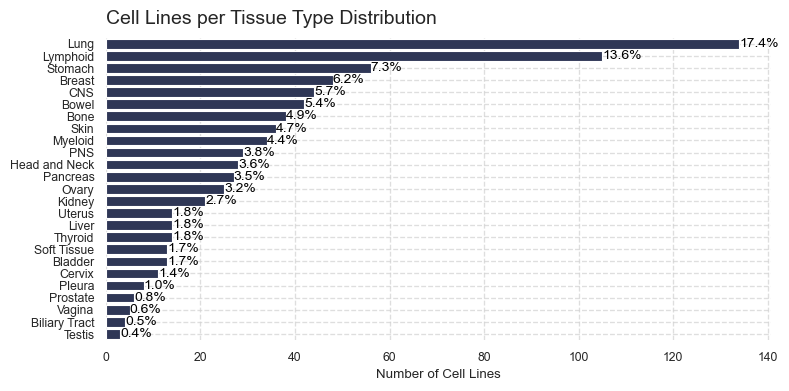

In [11]:
# Create a bar plot with the number of cell lines per tissue type (y-axis is the number of cell lines)
# Annotate percentages on top of the bars
plt.figure(figsize=(8, 4))
ax = sns.countplot(
    data=metadata,
    y="Tissue_type",
    order=metadata["Tissue_type"].value_counts().index,
    color=def_colors[0]
)
# Calculate percentages for the top of the bars
total = len(metadata["Tissue_type"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(
        percentage, 
        (x, y),
        ha='left',
        va='center',
        fontsize=10,
        color='black',
    )

# set x-axis label
ax.set_xlabel("Number of Cell Lines")
# set y-axis label
# ax.set_ylabel("Tissue Type",fontsize=14)
ax.set_ylabel("")
# set title
ax.set_title(
    "Cell Lines per Tissue Type Distribution",
    fontsize=14,
    loc="left",
    pad=10
)
# Add grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

sns.despine(
    left=True, 
    bottom=True
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CellLinesPerTissueType_barplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

metadata.groupby([
    "Tissue_type", 
    "Cancer_subtype"
]).size().sort_values(
    ascending=False
).head(25)

Her we can see the cancers from lung tissue has over 15% of all the cell lines, and upon closer look at the subtypes within tissues, lung has 2 subtypes on top with 55 and 46 cell lines each. While compared to some other tissues, these representations are quite a lot and might affect overall summaries. That's why I will be limiting the number of cell lines per subtype, age, tumour status to 3, by picking best quantified 3 cell lines per that group.

In here we limit the groups (defined as the Cancer subtype, tumour status[Metastatic or Primary], and age groups) to have up to 4 cell lines. This is done to avoid one group or tissue to be overrerpresented due to sheer number of cell lines and influence the analysis results. (e.g Lung cancers have more than 120 cell lines, while testicular cancers have only 3 cell lines).

> I am not sampling same number of cell lines per group, because some groups have less than 3 cell lines. I am sampling up to 4 cell lines per group.

**NOTE:** I will remove the Age as one of the grouping variable, since in the analysis I use Adult vs Child in one place and there the leukemias cancer types are already named with Adult and Child. So I will remove the age from the grouping variable.

In [12]:
# Adding a number of cell line limitation to over-represented groups 
cur_cutoff = 3
cv_weight = 0.25
cp_weight = 0.75
group_vars = ["Cancer_subtype", "Status"]
print(f"Limiting the number of cell lines per group ({group_vars}) to {cur_cutoff}")
print("-" * 50)
cl_per_group = metadata.groupby(group_vars)["SIDM"].nunique()
print("Number of unique groups:", len(cl_per_group), "eg. ({})".format(cl_per_group.index[0]))

many_per_group = cl_per_group[cl_per_group >= (cur_cutoff+1)]
print("Number of groups with more than {} cell lines: {}".format((cur_cutoff+1), len(many_per_group)))

# Create a subset of the replica_meta using the many_per_group
sub_meta = replica_meta.reset_index().set_index(
    group_vars
).loc[many_per_group.index]
# Create a cell line + columns dictionary from the many_per_groups
sub_lp_dict = sub_meta.groupby("SIDM").apply(
    lambda x: list(x["ColumnName"])
).to_dict()

# Calculate the qualityIndex score for each cell line
res_lst = []
# Loop over the cell lines
for k, v in sub_lp_dict.items():
    cur_subset = data[v]
    # Calculate median cv of the subset
    cur_cv = np.nanmedian(utils.cv_numpy(cur_subset.values))
    # Calculate number of complete proteins
    cur_cp = ((~(cur_subset.isna())).sum(axis=1) == len(v)).sum() / len(cur_subset)

    combined_score = (cv_weight * (1 - cur_cv)) + (cp_weight * cur_cp)

    res_lst += [combined_score]

# Create a dataframe from the combned scores
qi_df = pd.DataFrame(
    res_lst,
    index=sub_lp_dict.keys()
).rename(
    columns={0: "QualityIndex"}
).join(
    metadata.set_index("SIDM")[group_vars]
)

qi_df["SIDM"] = qi_df.index

# Pick the N highest quality index per group
target_cl = qi_df.groupby(group_vars).apply(
    lambda x: x.nlargest(cur_cutoff, "QualityIndex")
).reset_index(drop=True)["SIDM"].unique()

# Find cell lines to drop
drop_cl = set(qi_df["SIDM"]) - set(target_cl)
print(" - Dropping {} cell lines".format(len(drop_cl)))
# Drop them from replica_meta and metadata
replica_meta = replica_meta[~replica_meta["SIDM"].isin(drop_cl)].reset_index(drop=True)
metadata = metadata[metadata["SIDM"].isin(replica_meta["SIDM"])].reset_index(drop=True)
print(" - Number of cell lines after:", len(metadata["SIDM"].unique()))

print("Number of unique groups after:", len(metadata.groupby(group_vars)["SIDM"].nunique()))

# Drop cell lines from the quant data
pickedN_data = data[replica_meta["ColumnName"]]
# Remove proteins if all values are NaN
pickedN_data = pickedN_data[pickedN_data.isna().sum(axis=1)!=pickedN_data.shape[1]]
print("Data Shape:", pickedN_data.shape)
pickedN_data.head().iloc[:, :5]

Limiting the number of cell lines per group (['Cancer_subtype', 'Status']) to 3
--------------------------------------------------
Number of unique groups: 163 eg. (('Acute Promyelocytic Leukemia', 'Primary'))
Number of groups with more than 4 cell lines: 59
 - Dropping 412 cell lines
 - Number of cell lines after: 360
Number of unique groups after: 163
Data Shape: (8483, 2235)


ColumnName,M01|P05|SIDM00018|1,M03|P05|SIDM00018|1,M05|P05|SIDM00018|1,M06|P05|SIDM00018|1,M06|P05|SIDM00018|2
Acc_id,,,,,
Q9Y651,NaN,NaN,NaN,NaN,NaN
P37108,139.1393,117.3695,149.4772,143.8334,137.1311
Q96JP5,3.7153,11.9476,24.9003,9.1770,NaN
Q9Y4H2,NaN,NaN,NaN,NaN,NaN
P36578,243.5698,256.3872,184.5696,274.0709,256.0011


This dratically reduces the number of cell lines with 412 to 360 remaining, which is a good number to work with in the analysis. 

Another thing to note is that depending on the question this step can be updated to reflect that. Since for the current analysis I will be doing an overall high-level exploration of cancer cell line landscape the representative 3 is enought.


After the removal of the cell lines I will update some useful dictionaries used in the analysis going forward. 

**Updating the Useful Dictionaries**

In [13]:
## Create useful dictionaries to be used in the analysis
# Create a custom palette for the Tissues
cust_pal = sns.color_palette("tab20", metadata["Tissue_type"].unique().shape[0]) 
# Create a dictionary of the tissue types and colors
tissue_labels = dict(zip(metadata["Tissue_type"].sort_values().unique(), list(cust_pal.as_hex())))
# Create a dictionary to hold Cell-line: Tissue
cell_tissue = dict(zip(metadata["SIDM"], metadata["Tissue_type"]))
# Create a dictionary to hold Tissue: Cell-line
tissue_cell = metadata.groupby("Tissue_type").apply(lambda x: list(x["SIDM"])).to_dict()
# Create Cell_Line: ColumnName Dictionary
lp_dict = replica_meta.groupby(["SIDM"]).apply(lambda x: list(x["ColumnName"])).to_dict()

print("Metadata shape:", metadata.shape)
print("Cell lines (SIDM):", len(metadata["SIDM"].unique()))
# print("Cell lines (Names):", len(metadata["Cell_line"].unique()))
print("Systems:", len(metadata["System_name"].unique()))
print("Tissues:", len(metadata["Tissue_type"].unique()))
print("Cancer types:", len(metadata["Cancer_type"].unique()))
print("Cancer subtypes:", len(metadata["Cancer_subtype"].unique()))
print("Collection sites:", len(metadata["Collection_site"].unique()))
print("Status:", len(metadata["Status"].unique()), metadata["Status"].unique())
print("Ages:", len(metadata["Age"].unique()), metadata["Age"].unique())
metadata.head()

Metadata shape: (360, 10)
Cell lines (SIDM): 360
Systems: 11
Tissues: 25
Cancer types: 42
Cancer subtypes: 102
Collection sites: 35
Status: 2 ['Primary' 'Metastatic']
Ages: 2 ['Adult' 'Child']


,SIDM,Cell_line,System_name,Tissue_type,Cancer_type,Cancer_subtype,Collection_site,Status,Age,Sex
0,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
1,SIDM00875,HCC1806,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
2,SIDM00879,HCC1500,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
3,SIDM00629,MDA-MB-436,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Pleural_effusion,Metastatic,Adult,Female
4,SIDM00122,BT-549,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Breast,Primary,Adult,Female


## Cleanup the Quantification

In this section I do cleanup and filtering based on the quantification data. 

### Mean Impute and Remove Sparsely Quantified Proteins

I remov mostly missing proteins and imputed proteins with sparse missing values by using the mean of the protein for that sample. If a protein was quantified more than 60% within a cell line, the remaining values were replaced with the mean value for that protein in that specific sample. However, if a protein was quantified in less than 20% of samples per cell line, the quantified sample was cleaned to NaN, allowing it to be placed at a low value using downshifted imputation if desired. For any analysis conducted in this manuscript, we did not impute all the missing values. However, I am keeping this as an option if imputation is desired.

In [14]:
# Cleaning the quantification data for more robust analysis
avg_thr = 1 - 0.6
miss_thresh = 1 - 0.2

print("Cleaning the Quantification Data with the following criteria:")
print("  - Fill with Average if Missing Percentage is < {}".format(avg_thr))
print("  - Set to all to NaN if Missing Percentage is > {}".format(miss_thresh))
print("-" * 50)
print(
    "Number of Fully Retained Proteins Before Cleaning, {}".format(
        pickedN_data.dropna().shape[0]
    )
)

res_lst = []
cur_features = pickedN_data.index
# Loop through the cell lines
for cl, cols in lp_dict.items():
    # Subset the data for a selected cell line
    cl_sub_data = pickedN_data[cols].values

    # Calcualte missing count/percentage and quantified counts to help
    miss_col_cnt = np.isnan(cl_sub_data).sum(axis=1)
    # quan_col_cnt = (~cl_sub_data.isna()).sum(axis=1)
    miss_col_pct = (miss_col_cnt / len(cols))
    # Find indexes where NaN will be filled with the average
    fillwithAvg_idx = np.where(
        (miss_col_pct <= avg_thr) & 
        (miss_col_cnt != 0)
    )[0]
    # Find the mean value for fillwithAvg_idx
    avgProts = np.nanmean(
        cl_sub_data[fillwithAvg_idx], axis=1
    )
    # Find indexes where all values will be NaN
    allNaN_idx = np.where(
        (miss_col_pct >= miss_thresh) & 
        (miss_col_cnt != 1)
    )[0]
    # Find indices to keep as is
    keepAs_idx = np.array(list(
        set(range(len(cur_features))) - 
        (
            set(fillwithAvg_idx) | 
            set(allNaN_idx)
        )
    ))
    # Fill NaN with average
    for i in range(len(fillwithAvg_idx)):
        cl_sub_data[fillwithAvg_idx[i]] = np.nan_to_num(
            cl_sub_data[fillwithAvg_idx[i]], 
            nan=avgProts[i]
        )
    # Set NaN
    for i in range(len(allNaN_idx)):
        cl_sub_data[allNaN_idx[i]] = np.nan

    # Create a dataframe from the subsetted data
    cl_sub_data_df = pd.DataFrame(
        cl_sub_data, 
        index=cur_features, 
        columns=cols
    )
    # Append the dataframe to the list
    res_lst.append(cl_sub_data_df)

# Concatenate the list of dataframes
clean_data = pd.concat(res_lst, axis=1)

print(
    "Number of Fully Retained Proteins After Cleaning, {}".format(
        clean_data.dropna().shape[0]
    )
)

Cleaning the Quantification Data with the following criteria:
  - Fill with Average if Missing Percentage is < 0.4
  - Set to all to NaN if Missing Percentage is > 0.8
--------------------------------------------------
Number of Fully Retained Proteins Before Cleaning, 400
Number of Fully Retained Proteins After Cleaning, 725


With the imputation of the sparsely missing replicates per cell line for proteins, the number of fully retained proteins increased to 725. 

### Pick 5 Best Replicates per Cell Line

Since some cell lines have more than 6 replicates, I will pick the 5 best replicates per cell line based on the coefficient of variation (CV) of the replicates. The replicates with the lowest CV with lowest missing values will be picked.

In [15]:
# Picks best N replicates per cell line if there are more than N
cur_cutoff = 5
print(
    "Picking the best {} replicates per cell line".format(cur_cutoff)
)
print("-" * 50)
print("Number of samples - before:", clean_data.shape[1])

new_lp_dict = {}
for k, v in lp_dict.items():
    new_lp_dict[k] = utils.pick_best_replicates(clean_data[v], 5)

# overwrite the lp_dict
lp_dict = new_lp_dict

pickedN_data = pd.DataFrame()
for k, v in new_lp_dict.items():
    # concat
    pickedN_data = pd.concat(
        [
            pickedN_data,
            clean_data[v]
        ], 
        axis=1
    )

# Update the replica_meta
replica_meta = replica_meta[
    replica_meta["ColumnName"].isin(pickedN_data.columns)
]

print("Number of samples - after:", pickedN_data.shape[1])

Picking the best 5 replicates per cell line
--------------------------------------------------
Number of samples - before: 2235
Number of samples - after: 1800


This step is to make all cell lines have the same number of replicates and to ensure the replicates are the best ones to be used in the analysis.

### Remove Proteins if Fully Quantified in 1 or No Cell Line

At this stage I will remove the proteins that are quantified in only 1 or no cell line. This is prompted since I've removed some of the cell lines, which will make some of the proteins quantified in no cell line. or only 1 cell line. If it is fully quantified in only one cell line it won't be useful when we are comparing the cell lines in the statistical testing later on, hence I will remove them.

In [16]:
# Select the data to run (imputed or centered)
data2run = pickedN_data.copy()
# Create a dataframe to check the completeness of the data
check_data = (~data2run.isna())
cur_lst = []
# Loop through cell line - columns
for k,v in lp_dict.items():
    cur_lst.append(check_data.loc[:, v].sum(axis=1))
# Convert the completeness sum of list of series to a dataframe
check_data = pd.DataFrame(cur_lst, index=lp_dict.keys()).T

# Find proteins that are quantified in at least 2 cell lines
proteins2keep = check_data[(check_data == 5).sum(axis=1) >= 2].index
print(f"Number of Proteins Fully Quantified in Atleast 2 Cl: {len(proteins2keep)}")
# Update the data to run
data2run = data2run.loc[proteins2keep]

Number of Proteins Fully Quantified in Atleast 2 Cl: 7975


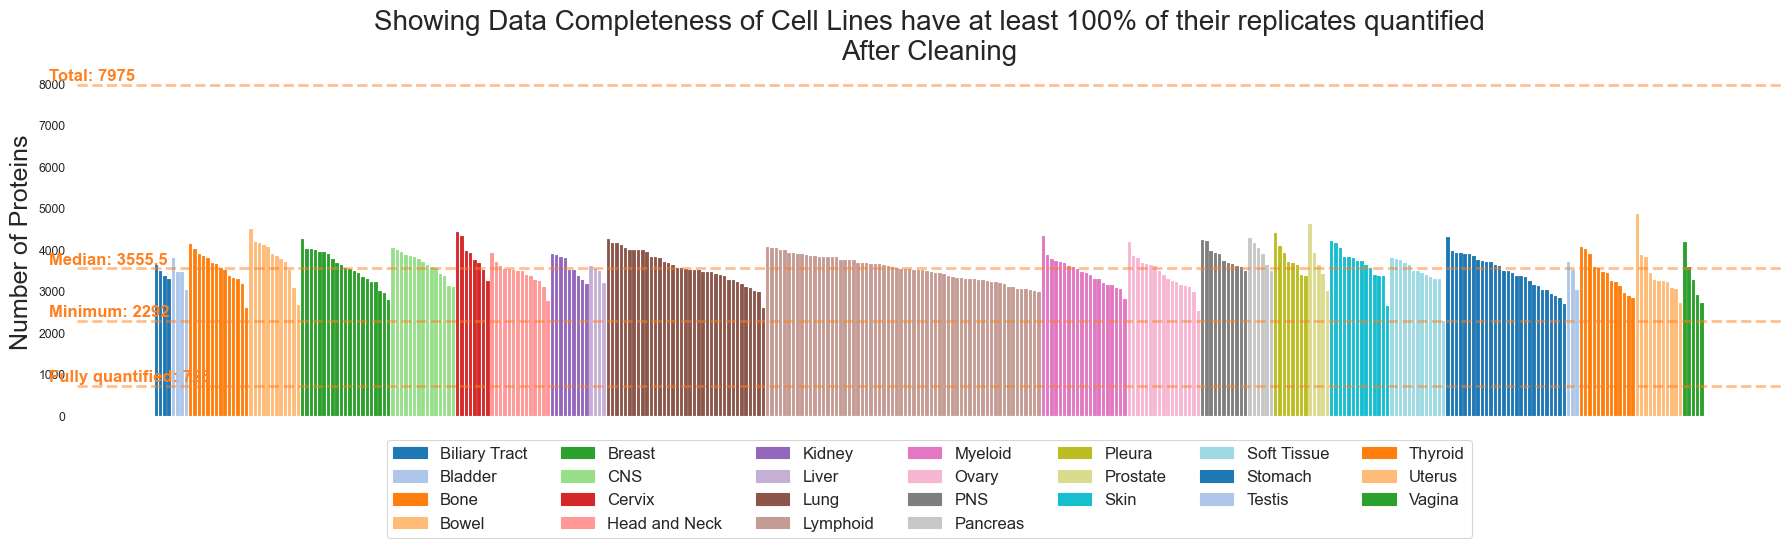

In [17]:
plots.check_completeness(
    data2run,
    loop_dict = new_lp_dict,
    hue_dict = cell_tissue,
    color_dict = tissue_labels,
    complete_threshold = 1,
    label_color = def_colors[3],
    group_name = "Cell Lines",
    title_add = "After Cleaning",
    feature_name= "Number of Proteins"
);

In this plot I wanted to plot the number of proteins quantified in each cell line grouped by their tissue.

# Data Processing

## Checking for Batch Effects

The version of the data is the procesed version, so I expect to see minimal to no batch effects. However, since I did remove quiet a few cell lines and proteins, I will check for batch effects to ensure the data is clean and ready to be used.

To do that I will plot the T-SNE plot of the averaged replicates of the cell line over fully quantified proteins, since any missing values will cause issue with the T-SNE plot. I will also color the points based on the tissue type. 

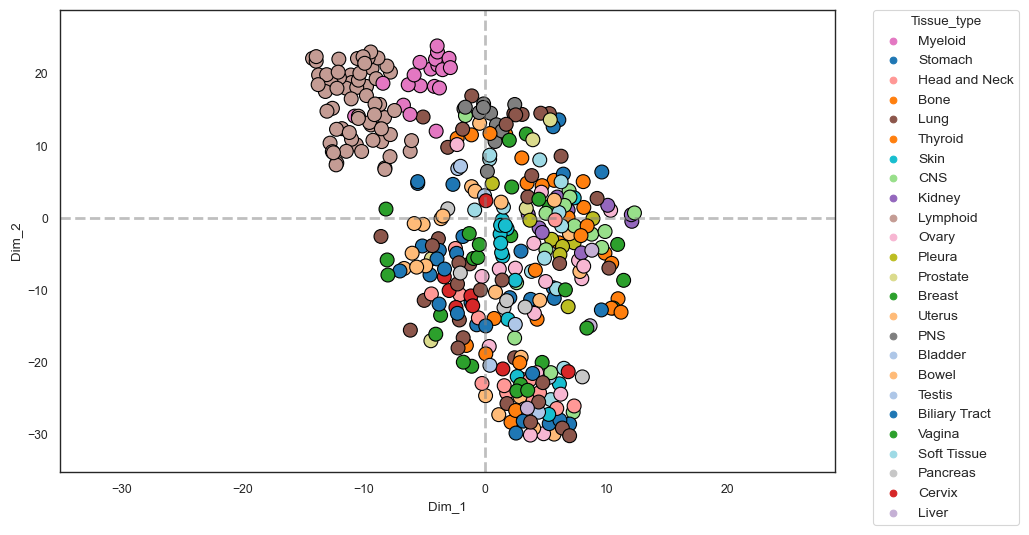

In [18]:
# Create collapsed data
plot_data = pd.DataFrame()
for k,v in new_lp_dict.items():
    plot_data[k] = data2run[v].mean(axis=1)

# plot_data = utils.scale_the_data(
#     plot_data.dropna(),
#     axis=1,
#     method="zscore"
# )

model, res = utils.apply_dimensional_reduction(
    np.log2(plot_data).dropna().T,
    method="tsne",
    metadata=metadata,
    metaindex="SIDM",
    metacols=["Age", "Sex", "Status", "System_name", "Tissue_type"],
    # TSNE parameters
    perplexity=30,
    learning_rate='auto',
    n_iter=2500,
)

plots.check_batch_effect(
    model,
    res, 
    # color_dict = dict(zip(metadata["System_name"].sort_values().unique(), list(cust_pal.as_hex()))),
    color_dict = tissue_labels,
    hue_name = "Tissue_type",
    # style_name = "Sex"
    style_name=None
);

In the original paper the hematopoeitic cell lines were showin distinct clustering, similarly here as well cell lines from Myeloid and Lymphoid tissue (aka Hematopoietic) are clustering together. However, rest is not showing any distinct clustering.

I don't think there is any need to touch the data further to remove any batch effects.

## Center the Medians

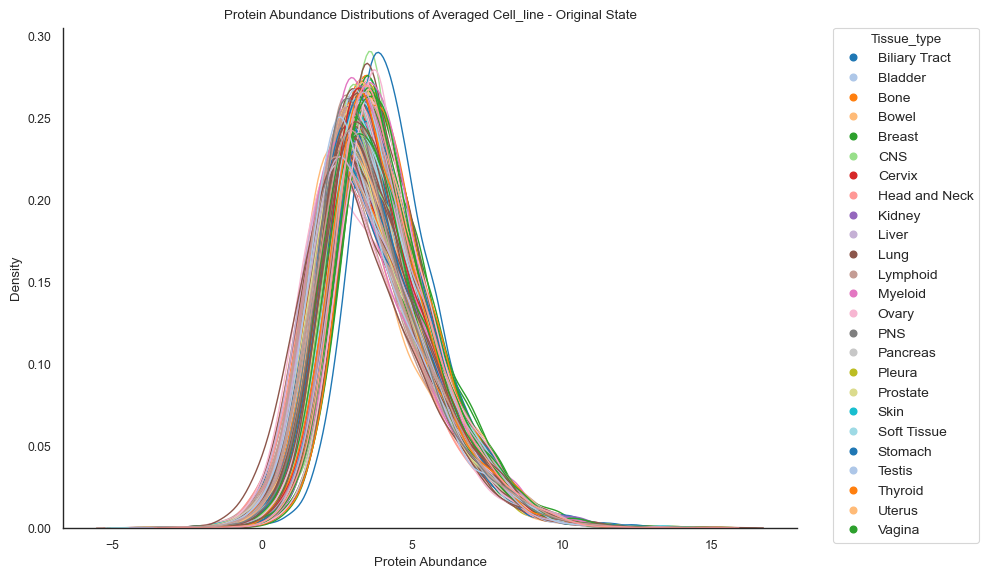

In [19]:
plots.check_distribution(
    np.log2(data2run),
    loop_dict=new_lp_dict,
    hue_dict=cell_tissue,
    color_dict=tissue_labels,
    title_add="Original State",
);

In [20]:
mag = np.nanmedian(data2run.values.flatten()).astype(int)

centered_data = ((data2run / data2run.median()) * mag)

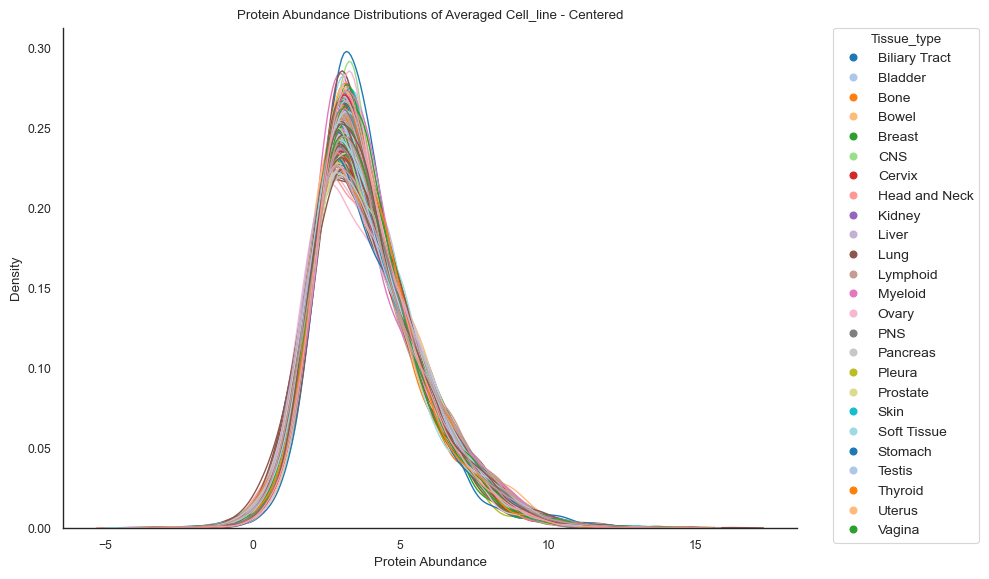

In [21]:
plots.check_distribution(
    np.log2(centered_data),
    loop_dict=new_lp_dict,
    hue_dict=cell_tissue,
    color_dict=tissue_labels,
    title_add="Centered",
);

## 90 Percentile Intra-CV of Cell Lines 

In here I plot 90th percentile of the intra-CV of the cell lines grouped by tissue to highlight what CV threshold I should use to exclude proteins during QuEStVar analysis.

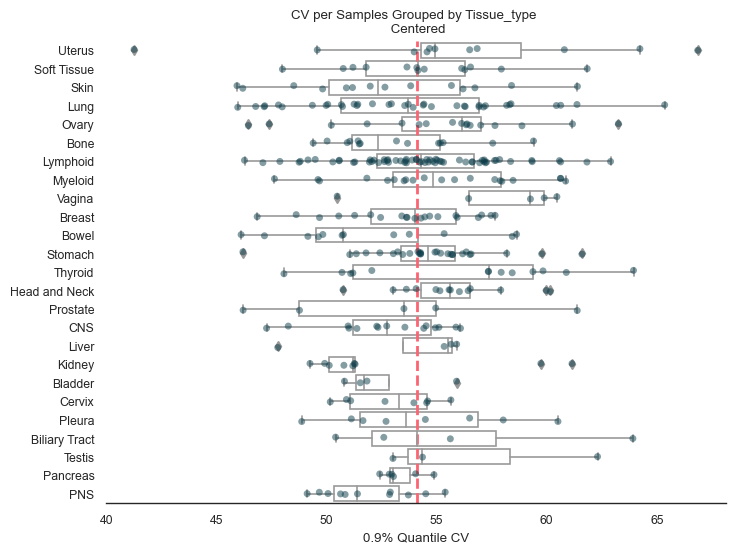

In [22]:
tmp_plot = plots.check_cv(
    centered_data,
    loop_dict=new_lp_dict,
    hue_dict=cell_tissue,
    title_add="Centered",
    picked_quantile=0.90
)

It seems around 75% CV threshold is a good threshold to use to exclude proteins from the analysis since no cell line has more than 70 at 95th percentile.

# Saving the Data

After completing the quality checks and necessary processing, I save the following data in the `.feather` format to be used in the testing phase of the next notebook. All of these data are stored in the `data/processed/` folder.

## Metadata Used

The unique cell line metadata used in this notebook is a simple table containing the sample names and the corresponding sample groups saved as `metadata.feather` in the `data/processed/` folder.

And the replicate metadata used in this notebook is a simple table containing the sample names and the corresponding sample groups saved as `replicate_meta.feather` in the `data/processed/` folder.

In [23]:
feather.write_dataframe(
    df=metadata, 
    dest=output_path+"metadata.feather"
)
print("Metadata saved to {}".format(output_path+"metadata.feather"))
print(metadata.shape)
metadata.head()

Metadata saved to ./data/processed/metadata.feather
(360, 10)


,SIDM,Cell_line,System_name,Tissue_type,Cancer_type,Cancer_subtype,Collection_site,Status,Age,Sex
0,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
1,SIDM00875,HCC1806,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
2,SIDM00879,HCC1500,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
3,SIDM00629,MDA-MB-436,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Pleural_effusion,Metastatic,Adult,Female
4,SIDM00122,BT-549,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Breast,Primary,Adult,Female


In [24]:
feather.write_dataframe(
    df=replica_meta, 
    dest=output_path+"replica_metadata.feather"
)
print("Replica saved to {}".format(output_path+"replica_metadata.feather"))
print(replica_meta.shape)
replica_meta.head()

Replica saved to ./data/processed/replica_metadata.feather
(1800, 15)


,SIDM,ColumnName,UniqueSample,VarianceID,Cell_line,Replicate,Batch,Sex,Age,Status,Collection_site,System_name,Tissue_type,Cancer_type,Cancer_subtype
0,SIDM00018,M01|P05|SIDM00018|1,M01|P05|SIDM00018,M01|P05,K052,1,M01,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
1,SIDM00018,M03|P05|SIDM00018|1,M03|P05|SIDM00018,M03|P05,K052,1,M03,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
2,SIDM00018,M05|P05|SIDM00018|1,M05|P05|SIDM00018,M05|P05,K052,1,M05,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
3,SIDM00018,M06|P05|SIDM00018|1,M06|P05|SIDM00018,M06|P05,K052,1,M06,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia
4,SIDM00018,M06|P05|SIDM00018|2,M06|P05|SIDM00018,M06|P05,K052,2,M06,Male,Adult,Primary,Bone_marrow,Hematologic,Myeloid,Acute Myeloid Leukemia,Adult Acute Myeloid Leukemia


## Cleaned Quant Data

The cleaned and processed protein-level quantitative data is saved as `clean_quantdata.feather` in the `data/processed/` folder. This data is saved as a reference if further analysis needs the full data without subsets. 

In [25]:
feather.write_dataframe(
    df=centered_data, 
    dest=output_path+"clean_quantdata.feather"
)
print("Cleaned quantification data saved to {}".format(output_path+"clean_quantdata.feather"))
print(centered_data.shape)
centered_data.head()

Cleaned quantification data saved to ./data/processed/clean_quantdata.feather
(7975, 1800)


,M01|P05|SIDM00018|1,M03|P05|SIDM00018|1,M05|P05|SIDM00018|1,M06|P05|SIDM00018|1,M06|P05|SIDM00018|2,M03|P05|SIDM00023|1,M05|P05|SIDM00023|1,M05|P05|SIDM00023|2,M05|P05|SIDM00023|3,M06|P05|SIDM00023|1,M01|P05|SIDM00043|1,M01|P05|SIDM00043|2,...,M03|P03|SIDM01219|1,M03|P03|SIDM01219|2,M01|P04|SIDM01247|1,M01|P04|SIDM01247|2,M02|P04|SIDM01247|1,M03|P04|SIDM01247|1,M04|P04|SIDM01247|1,M01|P04|SIDM01248|1,M01|P04|SIDM01248|2,M03|P04|SIDM01248|1,M04|P04|SIDM01248|1,M05|P04|SIDM01248|1
Acc_id,,,,,,,,,,,,,,,,,,,,,,,,,
Q9Y651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P37108,136.7131,107.1767,131.9774,161.2319,134.0485,80.2675,106.9808,90.2815,109.0093,128.5325,87.5311,91.3741,...,238.2961,184.4636,148.1745,152.4118,149.2214,141.8955,127.1492,77.4712,55.2392,40.8880,84.9212,68.9814
Q96JP5,3.6505,10.9101,21.9852,10.2871,12.1480,13.1413,23.8260,12.4551,24.1089,16.5129,19.1452,19.6299,...,11.7807,7.8821,14.9476,8.5048,10.8814,17.9601,16.1757,22.2542,27.6395,26.8163,19.1939,28.5285
Q9Y4H2,NaN,NaN,NaN,NaN,NaN,NaN,6.5174,NaN,2.6901,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P36578,239.3227,234.1214,162.9615,307.2233,250.2465,179.9862,206.9882,162.5768,208.3216,225.5732,185.8197,154.5982,...,325.0153,167.6222,181.0408,184.8667,128.7928,181.1871,133.7821,78.0141,172.5625,174.3571,319.7552,81.8488


## Create Sample Subset Data

Each sample is subseted into a seperate file and saved in the `data/processed/samples/` folder. This is done to make the testing process easier and faster. The subset files are named as `sampleName.feather` and contain the protein-level quant data for that sample only.

In [26]:
n = 0
# Loop through cell line - columns
for k,v in new_lp_dict.items():
    # Subset the data for a selected cell line 
    cl_sub_data = centered_data[v]
    # Save the cell line data to hard drive cl_path with feather
    feather.write_dataframe(cl_sub_data, quant_path+k+".feather")
    n += 1
    
print("Number of subset files saved:", n)
print("All subsetted data saved to {}".format(quant_path))

Number of subset files saved: 360
All subsetted data saved to ./data/processed/samples/


## Averaged Replicates Data

For this data all replicates are averaged into single sample column and it is saved as `averaged_quantdata.feather` in the `data/processed/` folder. This data is used for protein-rank related visualizations and overall reference. 

In [27]:
# Create collapsed data
average_data = pd.DataFrame()
for k,v in new_lp_dict.items():
    average_data[k] = data2run[v].mean(axis=1)

# Save the data to a feather file
feather.write_dataframe(
    average_data, 
    output_path + "averaged_quantdata.feather"
)
print("Averaged quantification data saved to {}".format(output_path + "averaged_quantdata.feather"))
print(average_data.shape)
average_data.head()

Averaged quantification data saved to ./data/processed/averaged_quantdata.feather
(7975, 360)


,SIDM00018,SIDM00023,SIDM00043,SIDM00045,SIDM00050,SIDM00051,SIDM00055,SIDM00056,SIDM00080,SIDM00081,SIDM00083,SIDM00086,...,SIDM01178,SIDM01183,SIDM01186,SIDM01187,SIDM01191,SIDM01194,SIDM01196,SIDM01203,SIDM01206,SIDM01219,SIDM01247,SIDM01248
Acc_id,,,,,,,,,,,,,,,,,,,,,,,,,
Q9Y651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6178,NaN,NaN,NaN
P37108,137.3901,110.0761,107.8404,73.9405,63.5611,82.1600,119.3761,83.7401,50.7688,55.3701,85.0061,83.6252,...,66.4011,94.4678,144.4451,90.0577,62.1151,70.5387,68.0420,43.2385,116.7107,227.9230,130.3740,80.4335
Q96JP5,12.4335,19.3804,20.5577,8.6273,15.3369,7.7925,12.1593,14.9254,14.4762,5.1790,5.5415,NaN,...,14.0515,11.1489,12.7769,NaN,16.2813,10.3848,NaN,4.2041,9.3307,9.3485,12.5094,31.3789
Q9Y4H2,NaN,5.1058,NaN,NaN,NaN,NaN,NaN,NaN,17.3179,NaN,NaN,12.0115,...,NaN,4.2346,NaN,NaN,NaN,0.7251,NaN,3.1175,NaN,NaN,NaN,NaN
P36578,242.9197,210.8121,173.7156,299.7880,239.7711,267.2222,259.2714,197.7019,156.6825,180.9261,186.7035,193.4620,...,246.7877,148.8203,146.9704,176.2236,213.4566,180.7671,198.1770,282.6860,187.0721,253.5591,148.1466,204.8152


## Protein Information

This contains the fasta information of the proteins in the data that is going to be used. The file name is `protein_info_data.feather`.

In [28]:
allProteins = average_data.index.tolist()
# uniprotMapper = feather.read_dataframe(f"{input_path}UniProtIDMapping.feather")
uniprotMapper = pd.read_csv(f"{input_path}UniProtIDMapping.csv")
proteinInfoData = pd.DataFrame(
    allProteins, 
    columns=["entry"]
).merge(
    uniprotMapper,
    how="left",
    on="entry"
)[
    [
        "entry", 
        "entryName", 
        "proteinDescription",
        "geneName"
    ]
]
# Save as feather
feather.write_dataframe(
    proteinInfoData,
    dest = output_path+"protein_info_data.feather"   
)

print("Protein info saved to {}".format(output_path+"protein_info_data.feather"))
print(proteinInfoData.shape)
proteinInfoData.head()

Protein info saved to ./data/processed/protein_info_data.feather
(7975, 4)


,entry,entryName,proteinDescription,geneName
0,Q9Y651,SOX21_HUMAN,Transcription factor SOX-21,SOX21
1,P37108,SRP14_HUMAN,ignal recognition particle 14 kDa protein,SRP14
2,Q96JP5,ZFP91_HUMAN,E3 ubiquitin-protein ligase ZFP91,ZFP91
3,Q9Y4H2,IRS2_HUMAN,Insulin receptor substrate 2,IRS2
4,P36578,RL4_HUMAN,Large ribosomal subunit protein uL4,RPL4


# Conclusion

This notebook is the first step in the analysis of the data. It is used to check the data, clean it, and prepare it for the testing phase. The data is cleaned by removing proteins with sparse quantification and imputing missing values for proteins with sparse data. Additionally, proteins that are only fully quantified in one sample are removed. This is to ensure that there is no bias introduced by having unequal sample sizes in the results. After the cleanup, the number of fully quantified proteins increased from 2656 to 4252. The cleaned data is saved as a feather file to be used in the testing phase in the next notebook.

In [29]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:00m:45s
